In [1]:
from fastai.text import *
import html
import pandas as pd

from spacy.lang.en import English
from spacy.symbols import ORTH

/root/py36venv/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load INSPIRE data

In [373]:
class PoolingLinearClassifier(nn.Module):
    def __init__(self, layers, drops):
        super().__init__()
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])

    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs,-1)

    def forward(self, input):
        if len(input) == 2:
            raw_outputs, outputs = input
            output = outputs[-1]
            sl,bs,_ = output.size()
            avgpool = self.pool(output, bs, False)
            mxpool = self.pool(output, bs, True)
            x = torch.cat([output[-1], mxpool, avgpool], 1)
            for l in self.layers:
                l_x = l(x)
                x = F.relu(l_x)
            return l_x, raw_outputs, outputs
        else:
            raw_outputs, outputs = input, input
            x = outputs
            for l in self.layers:
                l_x = l(x)
                x = F.relu(l_x)
            return l_x, raw_outputs, outputs


class TextPlusReferencesDataset(Dataset):
    def __init__(self, x_text, x_ref, y, backwards=False, sos=None, eos=None):
        self.x_text, self.x_ref, self.y, self.backwards, self.sos, self.eos = \
        x_text, x_ref, y, backwards, sos, eos
        
    def __getitem__(self, idx):
        x_text = self.x_text[idx]
        x_ref = self.x_ref[idx]
        if self.backwards: x_text = list(reversed(x_text))
        if self.eos is not None: x_text = x_text + [self.eos]
        if self.sos is not None: x_text = [self.sos] + x_text
        return np.array(x_text), x_ref, self.y[idx]

    def __len__(self):
        return len(self.x_text)

    
class MultiInputRNN(nn.Module):

    def __init__(self, rnn_encoder, final_classifier_layers, final_classifier_dropouts=[0.2, 0.1]):
        super(MultiInputRNN, self).__init__()
        self.text_network = rnn_encoder
        if hasattr(self.text_network, 'reset'):
            self.text_network.reset()
        self.reference_network = PoolingLinearClassifier(layers=[6,50], drops=[0.1])
        self.combined_network = PoolingLinearClassifier(layers=final_classifier_layers,
                                                        drops=final_classifier_dropouts)

#         self.reference_network = nn.Linear(in_features=6, out_features=50)
#         self.combined_network = nn.ModuleList([
#             LinearBlock(final_classifier_layers[i], final_classifier_layers[i + 1],
#                         final_classifier_dropouts[i]) for i in range(len(final_classifier_layers) - 1)])

    def forward(self, x_text, x_ref):
#         x_ref = (x_ref, x_ref)
        text_network_output = self.text_network(x_text)
        reference_network_output = self.reference_network(x_ref)
        concatenated_output = torch.cat((text_network_output[-1][-1][-1], text_network_output[-1][-1][-2],
                                         text_network_output[-1][-1][-3], reference_network_output[0]), dim=1)
        
        output = self.combined_network(concatenated_output)
        
        return output
    
    
class TextPlusRefModel(BasicModel):
    def get_layer_groups(self):
        m = self.model
        return [(m.text_network.encoder, m.text_network.dropouti),
                *zip(m.text_network.rnns, m.text_network.dropouths),
                (m.reference_network),
                (m.combined_network)]
    
    
def get_rnn_classifier(bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, qrnn=False):
    rnn_enc = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
    return MultiInputRNN(rnn_enc, layers, drops)

In [59]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('inspire_data_with_reference_fractions_and_num_references/')

In [60]:
CLAS_PATH=Path('inspire_data_with_reference_fractions_and_num_references/inspire_clas')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('inspire_data_with_reference_fractions_and_num_references/inspire_lm')
LM_PATH.mkdir(exist_ok=True)

In [61]:
inspire_data = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_with_reference_fractions_and_num_references.df')
train_data = pd.read_pickle('inspire_data_with_reference_fractions_and_num_references/inspire_data_augmented_train.df')

inspire_data = inspire_data.sample(frac=1).reset_index(drop=True)

In [6]:
inspire_data.iloc[:,:-2] = (inspire_data.iloc[:,:-2] - inspire_data.iloc[:,:-2].mean().values) / inspire_data.iloc[:,:-2].std().values
inspire_data.head()

,core_references_fraction_first_order,core_references_fraction_second_order,noncore_references_fraction_first_order,noncore_references_fraction_second_order,total_first_order_references,total_second_order_references,labels,text
0,0.130399,0.628263,0.247148,0.356646,-0.543280,-0.478730,1,Analysis of Solar Events in 2015 with the HAWC...
1,1.467157,1.772706,-0.575439,-0.706483,-0.196726,0.762196,2,Study of $J/\psi\to\mu^+\mu^-$ and $\psi\mathr...
2,0.586853,0.886651,-0.417923,-0.133544,-0.452082,-0.425038,2,Observation of a knee in the p+He energy spect...
3,-0.782509,-0.849086,-0.732956,-0.863130,-0.452082,-0.510785,1,Procedures of Software Integration Test and Re...
4,-0.782509,-0.845510,0.891954,-0.615145,-0.360884,-0.195445,1,"Statistical Model Analysis of (n, α) Cross Sec..."


## Prepare data for the Language Model

In [7]:
# Split the data into training (80 %) and validation (20 % splits)

df_trn, df_val = sklearn.model_selection.train_test_split(
    inspire_data, test_size=0.2)

df_trn = df_trn.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

trn_texts = np.array(df_trn['text'])
val_texts = np.array(df_val['text'])

In [23]:
print('{}, {}'. format(len(trn_texts), len(val_texts)))

148805, 37202


In [24]:
CLASSES = ['rejected', 'noncore', 'core']

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)


(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [26]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

In [9]:
class FastLoadTokenizer(Tokenizer):
    """
    Tokenizer which avoids redundant loading of spacy language model

    The FastAI Tokenizer class loads all the pipeline components of the spacy model which significantly increases
    loading time, especially when doing inference on CPU. This class inherits from the FastAI Tokenizer and is
    refactored to avoid redundant loading of the classifier.
    """
    def __init__(self):
        self.re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
        self.tok = English()
        for w in ('<eos>', '<bos>', '<unk>'):
            self.tok.tokenizer.add_special_case(w, [{ORTH: w}])

    def proc_all(self, ss):
        return [self.proc_text(s) for s in ss]

    def proc_all_mp(self, ss, ncpus=None):
        ncpus = ncpus or num_cpus() // 2
        with ProcessPoolExecutor(ncpus) as executor:
            return sum(executor.map(self.proc_all, ss), [])

In [10]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [41]:
def get_texts(df):
    labels = df[0].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[1].astype(str)
    texts = list(texts.apply(fixup).values)

    tokens = FastLoadTokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens, list(labels)

In [42]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None)

In [46]:
tok_trn, trn_labels = get_texts(df_trn)
tok_val, val_labels = get_texts(df_val)

In [47]:
len(tok_trn)

148805

In [48]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [49]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [50]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [51]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1664848),
 ('of', 967535),
 ('.', 800505),
 (',', 760402),
 ('-', 571965),
 ('and', 571234),
 ('in', 492803),
 ('a', 479946),
 ('t_up', 468657),
 ('to', 404513),
 ('for', 272323),
 ('is', 266206),
 ('we', 240948),
 (')', 231877),
 ('with', 216940),
 ('(', 202974),
 ('$', 182384),
 ('\\', 180445),
 ('1', 176536),
 ('\n', 169007),
 ('<', 163759),
 ('that', 161951),
 ('>', 159387),
 ('are', 158352),
 ('xbos', 148805)]

In [52]:
max_vocab = 60000
min_freq = 2

In [53]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [54]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [55]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [56]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [57]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [58]:
vs=len(itos)
vs,len(trn_lm)

(60002, 148805)

## wikitext103 conversion

In [ ]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [60]:
em_sz,nh,nl = 400,1150,3

In [61]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [62]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [63]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [64]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [65]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [66]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [67]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [68]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [69]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [70]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [71]:
learner.model.load_state_dict(wgts)

In [72]:
lr=1e-3
lrs = lr

In [73]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      4.564378   4.273943   0.311521  



[4.273942588568528, 0.3115207118085827]

In [74]:
learner.save('lm_last_ft')

In [75]:
learner.load('lm_last_ft')

In [76]:
learner.unfreeze()

In [77]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.390401   4.156141   0.319849  



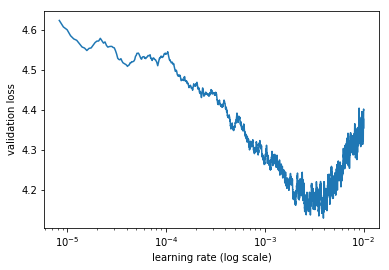

In [78]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                       
    0      3.992848   3.744761   0.357756  
    1      3.827055   3.609629   0.369511                       
    2      3.740297   3.540745   0.375842                       
 44%|████▎     | 5224/11995 [11:09<14:27,  7.81it/s, loss=3.7] 

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

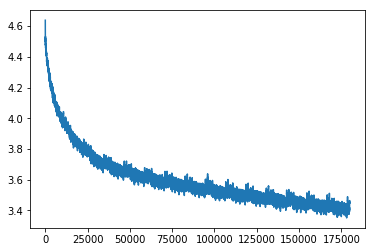

In [83]:
learner.sched.plot_loss()

## Classifier Tokens

In [11]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None)

In [12]:
def get_texts_classifier(df):
    labels = df[6].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[7].astype(str)
    texts = list(texts.apply(fixup).values)
    refs = np.array([df[0].values.astype(np.float32), df[1].values.astype(np.float32),
            df[2].values.astype(np.float32), df[3].values.astype(np.float32),
            df[4].values.astype(np.float32), df[5].values.astype(np.float32)])
    tokens = FastLoadTokenizer().proc_all_mp(partition_by_cores(texts))
    return tokens, refs.T, list(labels)

In [13]:
tok_trn_text, tok_trn_ref, trn_labels = get_texts_classifier(df_trn)
tok_val_text, tok_val_ref, val_labels = get_texts_classifier(df_val)

In [14]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn_text.npy', tok_trn_text)
np.save(CLAS_PATH/'tmp'/'tok_val_text.npy', tok_val_text)

np.save(CLAS_PATH/'tmp'/'tok_trn_ref.npy', tok_trn_ref)
np.save(CLAS_PATH/'tmp'/'tok_val_ref.npy', tok_val_ref)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [416]:
tok_trn_text = np.load(CLAS_PATH/'tmp'/'tok_trn_text.npy')
tok_val_text = np.load(CLAS_PATH/'tmp'/'tok_val_text.npy')

tok_trn_ref = np.load(CLAS_PATH/'tmp'/'tok_trn_ref.npy')
tok_val_ref = np.load(CLAS_PATH/'tmp'/'tok_val_ref.npy')

In [417]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [418]:
trn_clas_text = np.array([[stoi[o] for o in p] for p in tok_trn_text])
val_clas_text = np.array([[stoi[o] for o in p] for p in tok_val_text])

In [419]:
np.save(CLAS_PATH/'tmp'/'trn_ids_text.npy', trn_clas_text)
np.save(CLAS_PATH/'tmp'/'val_ids_text.npy', val_clas_text)

## Classifier

In [420]:
trn_clas_text = np.load(CLAS_PATH/'tmp'/'trn_ids_text.npy')
val_clas_text = np.load(CLAS_PATH/'tmp'/'val_ids_text.npy')

In [421]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
print('{}, {}'.format(len(trn_labels), len(val_labels)))

148805, 37202


In [422]:
trn_clas_text = trn_clas_text[0:-1]
tok_trn_ref = tok_trn_ref[0:-1]
trn_labels = trn_labels[:-1]

In [423]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 9

In [424]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [425]:
trn_ds = TextPlusReferencesDataset(trn_clas_text, tok_trn_ref, trn_labels)
val_ds = TextPlusReferencesDataset(val_clas_text, tok_val_ref, val_labels)
trn_samp = SortishSampler(trn_clas_text, key=lambda x: len(trn_clas_text[x]), bs=bs//2)
val_samp = SortSampler(val_clas_text, key=lambda x: len(val_clas_text[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [426]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [427]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3 + 50, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [428]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [429]:
learn = RNN_Learner(md, TextPlusRefModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [430]:
learn.crit = partial(F.cross_entropy, weight=Variable(torch.Tensor([10.0, 0.8, 0.8]).cuda()))

In [431]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [432]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2,1e-2])

In [433]:
wd = 1e-7
wd = 0
load_model(learn.model.text_network, 'inspire_data_with_reference_fractions_and_num_references/models/lm1_enc.h5')

In [434]:
learn.freeze_to(-1)

 68%|██████▊   | 25476/37201 [22:35<10:23, 18.80it/s, loss=1.46] 

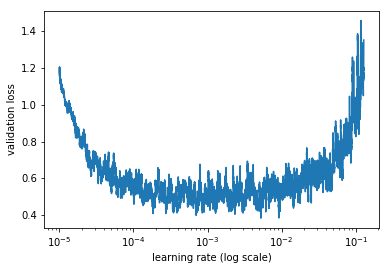

In [435]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [436]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.464056   0.297877   0.842186  


[0.2978765931407828, 0.8421859131972464]

In [437]:
learn.save('clas_0_bs10')

In [438]:
learn.load('clas_0_bs10')

In [439]:
learn.freeze_to(-2)

In [440]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.476261   0.311047   0.85361   


[0.3110474403972626, 0.8536100295028788]

In [441]:
learn.save('clas_1_bs10')

In [442]:
learn.load('clas_1_bs10')

In [443]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.340148   0.250865   0.881592  
  0%|          | 0/37201 [00:00<?, ?it/s]

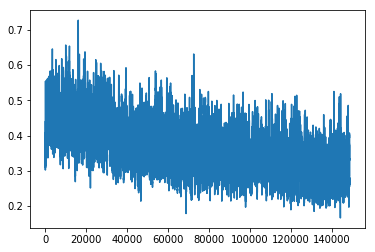

In [445]:
learn.sched.plot_loss()

In [446]:
learn.save('clas_2_bs10')

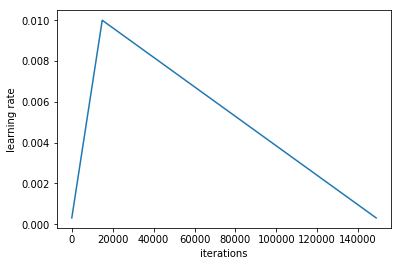

In [447]:
learn.sched.plot_lr()

## Make predictions

In [448]:
%%time

preds, target = learn.predict_with_targs()

CPU times: user 3min 17s, sys: 53.1 s, total: 4min 10s
Wall time: 4min 10s


In [177]:
# Calcualate the inference times
time_taken = 3 * 60 + 17
time_per_sample = time_taken / len(target)
print('Time per sample: {} s'.format(time_per_sample))
print('Samples per second: {}'.format(1/time_per_sample))

Time per sample: 0.014558084540348803 s
Samples per second: 68.69035532994924


In [449]:
pred = preds.argmax(axis=1)

In [450]:
from sklearn.metrics import confusion_matrix

In [451]:
conf_mat = confusion_matrix(target, pred, labels = [0, 1, 2])

In [452]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.97514 0.0215  0.00336]
 [0.08446 0.82127 0.09427]
 [0.03268 0.07338 0.89394]]


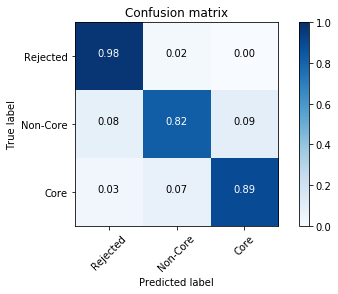

In [453]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

Confusion matrix, without normalization
[[ 7845   173    27]
 [ 1292 12563  1442]
 [  453  1017 12390]]


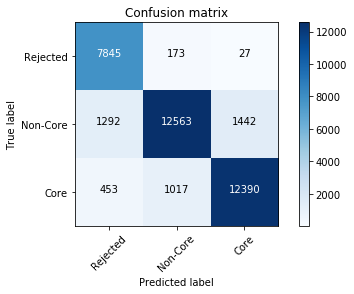

In [455]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=False)
plt.show()

In [476]:
learn.model.combined_network.layers[0]

LinearBlock(
  (lin): Linear(in_features=1250, out_features=50, bias=True)
  (drop): Dropout(p=0.2)
  (bn): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

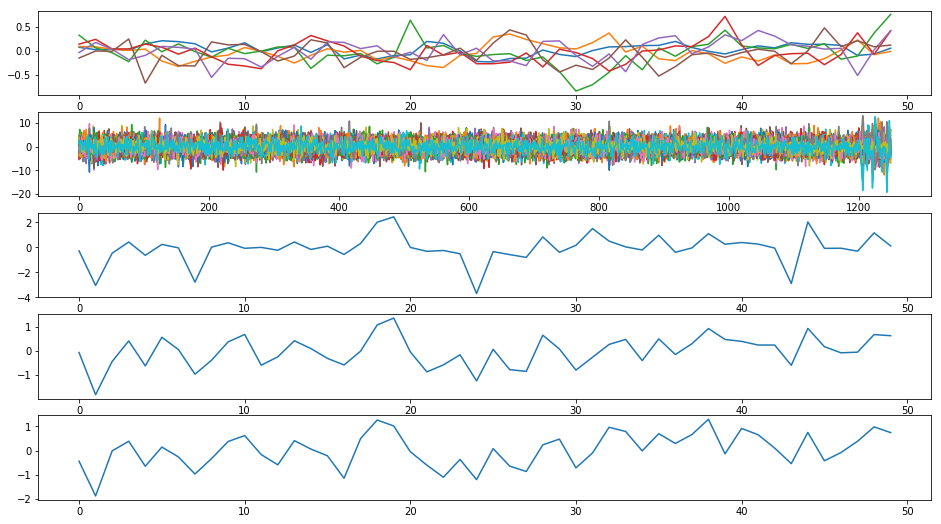

In [479]:
plt.figure(figsize=(16, 9))
plt.subplot(511)
plt.plot(learn.model.reference_network.layers[0].lin.weight.cpu().detach().numpy())
plt.subplot(512)
plt.plot(learn.model.combined_network.layers[0].lin.weight.cpu().detach().numpy().T)
plt.subplot(513)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,0])
plt.subplot(514)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,1])
plt.subplot(515)
plt.plot(learn.model.combined_network.layers[1].lin.weight.cpu().detach().numpy().T[:,2])

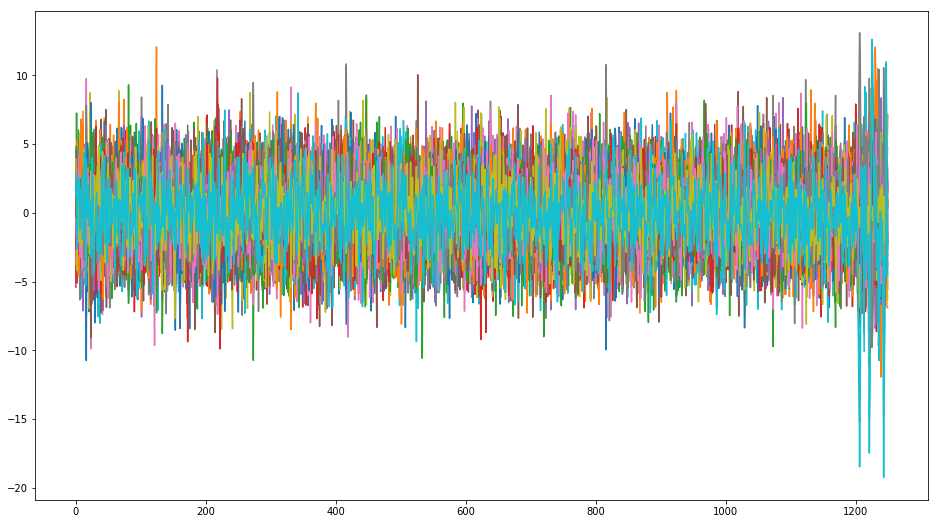

In [481]:
plt.figure(figsize=(16, 9))
plt.plot(learn.model.combined_network.layers[0].lin.weight.cpu().detach().numpy().T)